# Configurations & Inputs

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
#dataset_input_dir = "dataset/"
dataset_input_dir = "/content/drive/MyDrive/stuff/"
dataset_output_dir = "/content/drive/MyDrive/stuff/"

user_dataset_input = dataset_input_dir + "users-details-2023.csv"                                                                                                                                                                                                   #p@stwi2x
anime_dataset_input = dataset_input_dir + "anime-dataset-2023.csv"
rating_dataset_input = dataset_input_dir + "users-score-2023.csv"

anime_dataset_output = dataset_output_dir + "anime_embeddings.csv"
user_dataset_output = dataset_output_dir + "user_embeddings.csv"
# unified_dataset_output = dataset_output_dir + "unified_dataset_prep.csv"

from pyspark.sql import SparkSession
spark = SparkSession\
    .builder \
    .appName("Spark SQL app")\
    .config('spark.eventLog.gcMetrics.youngGenerationGarbageCollectors', 'true')\
    .getOrCreate()

# Data pre-processing

The object of this section is to pre-process data in a general matter before algorithm-specific pre-processing.

We have 3 datasets. Rating dataset as relation between user and anime titles, user and anime datasets as side information on the users and items in the recommendation problem.

Our pre-processing plan is as follows:
1. Data cleaning: remove duplicate records, synchronize formats.
2. Data transformation: value transformation, normalization, discretization.
3. Data integration: join into a unified dataset.
4. Data reduction: convert all data (except user and anime ids) into one single feature for specifically ALS model.

## Related functions
Customized functions to use in the later sessions.

##### Simple function(s)

In [7]:
from pyspark.sql.functions import col, isnan, trim
def print_shape(dataFrame):
    print(dataFrame.count(), len(dataFrame.columns))

def is_missing(c):
    return (col(c).isNull() | isnan(col(c)) | (trim(col(c)) == ''))

##### Saving dataframe

In [8]:
# credit: https://stackoverflow.com/a/47449433 + ChatGPT
import shutil
import os
import re
from pyspark.sql import DataFrame

def save_df_to_csv(df: DataFrame, csv_output: str, sep: str = ",", header: bool = False):
    tmp_parquet_dir = "Posts.tmp.parquet"

    # Write the DataFrame to a temporary directory in CSV format
    df.repartition(1).write \
        .format("csv") \
        .option("header", True) \
        .option("escape", '"')\
        .option("multiline", True)\
        .option("sep", ",")\
        .option("delimiter", sep) \
        .save(tmp_parquet_dir)

    # Locate the part file that was written
    for file_name in os.listdir(tmp_parquet_dir):
        if re.match(r"part-00000.*\.csv", file_name):
            tmp_csv_file = os.path.join(tmp_parquet_dir, file_name)
            break
    else:
        raise FileNotFoundError("CSV part file not found in temp directory.")

    # Rename/move the part file to the desired output location
    shutil.move(tmp_csv_file, csv_output)

    # Clean up temporary files
    shutil.rmtree(tmp_parquet_dir)

##### Dataset column syntax

In [9]:
def fix_syntax(dataFrame):
    # replace ' ' with '_'
    to_change = {}
    column_order = list(dataFrame.columns)
    for i in range(len(column_order)):
        if ' ' in column_order[i]:
            new_name = column_order[i].replace(' ', '_')

            to_change[column_order[i]] = new_name
            column_order[i] = new_name

    dataFrame = dataFrame.withColumnsRenamed(to_change)

    # replace other symbols
    import re
    to_change = {}
    for i in range(len(column_order)):
        new_name = re.sub(r"[!@#$.,'`]","", column_order[i]).replace('.', '')

        if new_name != column_order[i]:
            to_change[column_order[i]] = new_name
            column_order[i] = new_name

    dataFrame = dataFrame.withColumnsRenamed(to_change)
    return dataFrame

def fix_syntax_name(str):
    # replace ' ' with '_'
    new_name = str.replace(' ', '_')

    # replace other symbols
    import re
    new_name = re.sub(r"[!@#$.,'`]","", new_name).replace('.', '')

    return new_name

def fix_syntax_arr(arr):
    for i in range(len(arr.keys())):
        temp = fix_syntax_name(list(arr.keys())[i])
        if temp != list(arr.keys())[i]:
            arr[temp] = arr[list(arr.keys())[i]]
            arr.pop(list(arr.keys())[i], None)
    return arr

##### One-hot encoding

In [10]:
# cre: https://stackoverflow.com/questions/72600575/one-hot-encoding-to-a-list-feature-pyspark
import gc
from pyspark.sql.functions import array_contains, split, col, explode
def unique_categories(dataFrame, colName, show: bool = True):
    L = dataFrame.select(colName).rdd.flatMap(lambda x: x).collect()
    valueSet = {}
    for i in L:
        if i is not None:
            temp = i.split(", ")
            for j in temp:
                if colName + "_" + j not in valueSet.keys():
                    valueSet.update({colName + "_" + j: 1})
                else:
                    valueSet[colName + "_" + j] += 1
    if show:
        print(valueSet)
    return valueSet
def oneHotEncoding(dataFrame, colName: str, show: bool = True, support: int = 0):
    size_before = dataFrame.count()

    test_df = dataFrame.select(colName)

    # collect list of unique genres
    test_df = test_df.select('*', split(test_df[colName], ',').alias('tags'))

    tags = [x[0]
        for x in
        test_df.select(explode('tags')).collect()
    ]

    # support check
    tags_count = {}
    for tag in tags:
        if tag not in tags_count.keys():
            tags_count[tag] = 0
        tags_count[tag] += 1

    tag_list = list(tags_count.keys())
    for tag in tag_list:
        if tags_count[tag] < support:
            tags_count.pop(tag, None)

    tags_count = {fix_syntax_name(k): v for k, v in tags_count.items()}
    tags = tags_count.keys()

    # transfer unique values to panda DF to map the entries
    test_df = test_df.select(colName,
        *[
            array_contains('tags', tag).alias((colName + "_{}").format(tag)).cast("integer")\
            for tag in tags
        ]
    ).dropDuplicates()

    result_df = dataFrame.join(test_df, dataFrame[colName] == test_df[colName], 'left')\
        .drop(colName)

    for i in tags:
        result_df = result_df.na.fill({colName+"_"+i: 0})

    # store the embedding column list

    return result_df


#### Plot

In [11]:
from pyspark.sql.functions import min, max, col
import pandas as pd

def plotBar(dataFrame, colName: str, bins: int = 20, Figsize = (10, 8)):
    gre_histogram = dataFrame.select(colName)\
        .filter(col(colName).isNotNull())\
        .rdd.flatMap(lambda x: x).map(float).histogram(bins)
    pd.DataFrame(list(zip(*gre_histogram)),columns=['bin', 'frequency'])\
        .set_index('bin').plot(kind='bar', figsize=Figsize)

## User dataset

### Dataset

We input the dataset

In [ ]:
user_df = spark.read\
    .option("header", True)\
    .option("escape", '"')\
    .option("multiline", True)\
    .option("sep", ",")\
    .csv(user_dataset_input)

user_df.show(3, truncate=False)

+------+--------+------+-------------------------+--------------------+-------------------------+------------+----------+--------+---------+-------+-------+-------------+-------------+---------+----------------+
|Mal ID|Username|Gender|Birthday                 |Location            |Joined                   |Days Watched|Mean Score|Watching|Completed|On Hold|Dropped|Plan to Watch|Total Entries|Rewatched|Episodes Watched|
+------+--------+------+-------------------------+--------------------+-------------------------+------------+----------+--------+---------+-------+-------+-------------+-------------+---------+----------------+
|1     |Xinil   |Male  |1985-03-04T00:00:00+00:00|California          |2004-11-05T00:00:00+00:00|142.3       |7.37      |1.0     |233.0    |8.0    |93.0   |64.0         |399.0        |60.0     |8458.0          |
|3     |Aokaado |Male  |NULL                     |Oslo, Norway        |2004-11-11T00:00:00+00:00|68.6        |7.34      |23.0    |137.0    |99.0   |44.0

Dataset information

In [ ]:
print_shape(user_df)
print(user_df.columns)

731290 16
['Mal ID', 'Username', 'Gender', 'Birthday', 'Location', 'Joined', 'Days Watched', 'Mean Score', 'Watching', 'Completed', 'On Hold', 'Dropped', 'Plan to Watch', 'Total Entries', 'Rewatched', 'Episodes Watched']


### Data preprocessing

#### Mal ID

For better formatting, it is best that we rename this to 'user_id' to match with the rating dataset.

In [ ]:
user_df = user_df.withColumnRenamed(existing='Mal ID', new='user_id')

And we drop illegible entries when user_id is not there.

In [ ]:
from pyspark.sql.functions import col, isnan
user_df = user_df.filter(~is_missing('user_id'))

#### Username

Username does not have any impact in analysis, and we already have 'user_id' as a representation for users and it is an integer instead of a string.

We shall drop this column.

In [ ]:
user_df = user_df.drop('Username')

#### Gender

Since this is a categorical column, we count the distinct values.

In [ ]:
user_df.select('Gender').distinct().collect()

[Row(Gender='Female'),
 Row(Gender='Non-Binary'),
 Row(Gender='Male'),
 Row(Gender=None)]

As this categorical column has 3 non-null values at most, we perform one-hot encoding.

In [ ]:
user_df = oneHotEncoding(user_df, 'Gender')

And for NULL values generated from missing value in the 'Gender' column, we simply view them as not belonging to any of the genders.

In [ ]:
user_df = user_df.na.fill({'Gender_Female': 0, 'Gender_Male': 0, 'Gender_Non-Binary': 0})

#### Birthday

In [ ]:
from pyspark.sql.functions import col
user_df.select('Birthday').filter(col('Birthday').isNotNull()).show(3, truncate=False)

+-------------------------+
|Birthday                 |
+-------------------------+
|1985-03-04T00:00:00+00:00|
|1988-01-25T00:00:00+00:00|
|1988-02-22T00:00:00+00:00|
+-------------------------+
only showing top 3 rows



This column indicates the user's birthday, in the form of a timestamp.

We shall convert the non-null values in the form of timestamp to int.

In [ ]:
from pyspark.sql.functions import split, unix_timestamp, col, isnan, trim
from pyspark.sql.types import DoubleType
cur_col = 'Birthday'
split_col = split(user_df[cur_col], 'T', 2)
user_df = user_df.withColumn(cur_col+'_d', split_col.getItem(0))\
    .withColumn(cur_col+'_unix', unix_timestamp(cur_col+'_d', format='yyyy-mm-dd'))\
    .drop(cur_col, cur_col+'_d')\
    .withColumnRenamed(cur_col+'_unix', cur_col)\
    .withColumn(cur_col, col(cur_col).cast(DoubleType()))\
    .filter(col(cur_col).isNotNull() & ~isnan(col(cur_col)) & (trim(col(cur_col)) != ""))

In [ ]:
user_df.select('Birthday').where('Birthday is not NULL').show(5)

+-----------+
|   Birthday|
+-----------+
|4.7364498E8|
|5.7006726E8|
|5.6980812E8|
|6.3184332E8|
|4.1091906E8|
+-----------+
only showing top 5 rows



We shall look into value distribution to check outliers.

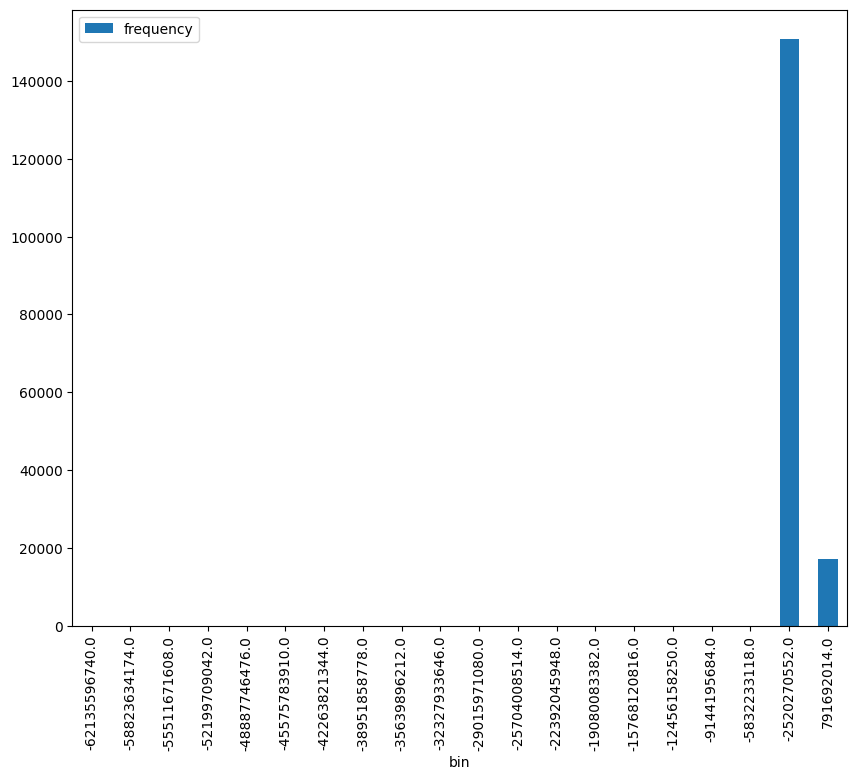

In [ ]:
plotBar(user_df, colName='Birthday', bins=20)

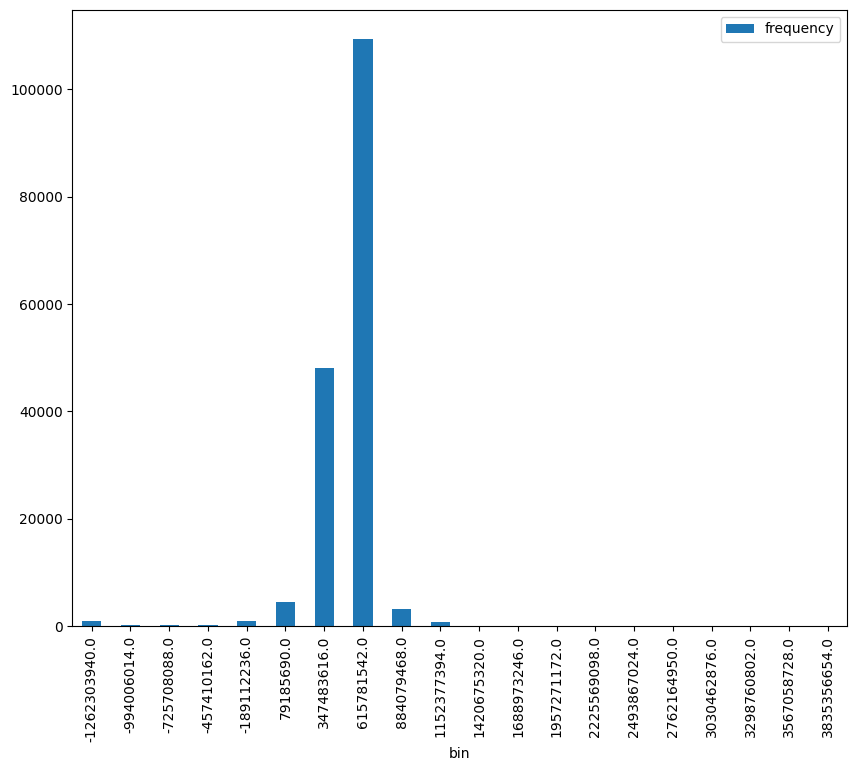

In [ ]:
plotBar(user_df.filter('Birthday >= -2e+9'), colName='Birthday', bins=20)

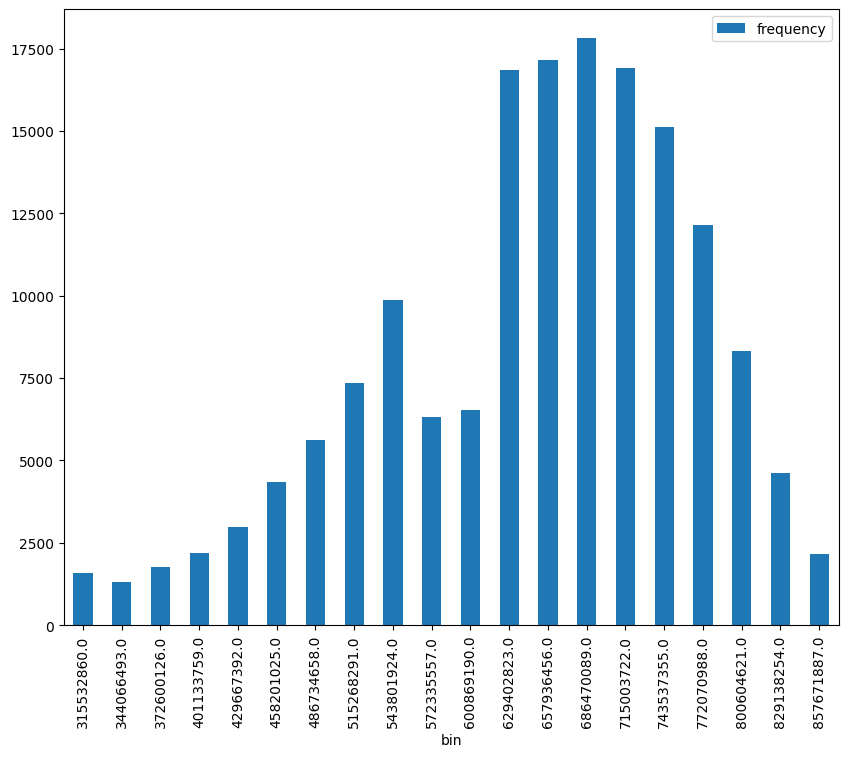

In [ ]:
plotBar(user_df.filter('Birthday >= 3e+8 and Birthday <= 9e+8'), colName='Birthday', bins=20)

The feature has most entries in the range of [3e8, 8e8], which represents the group of birthday years of 1979-1995. It is worth noting that during the 1990-2000 eras, anime spiked in popularity, and anime is watched more amongst teenagers than others.

Our plan: We deal with missing values by filling mean, then perform discretization, transforming into 3 categories using quantiles, and drop the original column for simplicity.

In [ ]:
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import when, col, isnan, trim, mean

user_df = user_df.na.fill({'Birthday': user_df.select(mean('Birthday')).collect()[0][0]})

temp_df = user_df.select('Birthday')\
    .filter(col('Birthday').isNotNull() & ~isnan(col('Birthday')) & col('Birthday').cast('double').isNotNull())

quantiles = temp_df.toPandas().quantile([0.1, 0.9])
print(quantiles)

        Birthday
0.1  474509220.0
0.9  820541100.0


In [ ]:
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col

cur_col = 'Birthday'
user_df = user_df.withColumn(cur_col+'_A', col(cur_col) < quantiles.loc[0.1, cur_col])\
    .withColumn(cur_col+'_B', (col(cur_col) >= quantiles.loc[0.1, cur_col]) & (col(cur_col) <= quantiles.loc[0.9, cur_col]))\
    .withColumn(cur_col+'_C', col(cur_col) > quantiles.loc[0.9, cur_col])\
    .withColumn(cur_col+'_A1', col(cur_col+'_A').cast(IntegerType())).drop(cur_col+'_A')\
    .withColumn(cur_col+'_B1', col(cur_col+'_B').cast(IntegerType())).drop(cur_col+'_B')\
    .withColumn(cur_col+'_C1', col(cur_col+'_C').cast(IntegerType())).drop(cur_col+'_C')\
    .withColumnsRenamed({cur_col+'_A1': cur_col+'_A', cur_col+'_B1': cur_col+'_B', cur_col+'_C1': cur_col+'_C'})\
    .drop(cur_col)

#### Location

In [ ]:
user_df.select('Location').where('Location is not NULL').show()

+--------------------+
|            Location|
+--------------------+
|          California|
|      Bergen, Norway|
|              Canada|
|         Calgary, AB|
|       Paris, France|
|      London,England|
| Lule&aring;, Sweden|
|     Ontario, Canada|
|Locked up in Shuu...|
|    Tampere, Finland|
|       Finland, Pori|
|      Drøbak, Norway|
|Yorba Linda, Cali...|
|         Pandan Jaya|
|            New york|
|     Johor, Malaysia|
|            Michigan|
|   Helsinki, Finland|
|Wilmington, North...|
|             Belgium|
+--------------------+
only showing top 20 rows



As you can see, the location format is very inconsistent, going back and forth between cities and/or countries and imcomprehensible values.

It is better for us to drop this column, for now.

In [ ]:
user_df = user_df.drop('Location')

#### Joined

In [ ]:
from pyspark.sql.functions import col
user_df.select('Joined').filter(col('Joined').isNotNull()).show(3, truncate=False)

+-------------------------+
|Joined                   |
+-------------------------+
|2004-11-05T00:00:00+00:00|
|2005-01-05T00:00:00+00:00|
|2005-01-23T00:00:00+00:00|
+-------------------------+
only showing top 3 rows



This column indicates the day user joined the platform, in the form of a timestamp.

We shall perform the same as column Birthday.

In [ ]:
from pyspark.sql.functions import split, unix_timestamp
cur_col = 'Joined'
split_col = split(user_df[cur_col], 'T', 2)
user_df = user_df.withColumn(cur_col+'_d', split_col.getItem(0))\
    .withColumn(cur_col+'_unix', unix_timestamp(cur_col+'_d', format='yyyy-mm-dd'))\
    .drop(cur_col, cur_col+'_d')\
    .withColumnRenamed(cur_col+'_unix', cur_col)

In [ ]:
user_df.select(cur_col).filter(col(cur_col).isNotNull()).show(3, truncate=False)

+----------+
|Joined    |
+----------+
|1073261460|
|1104883260|
|1106438460|
+----------+
only showing top 3 rows



Then we check the value distribution.

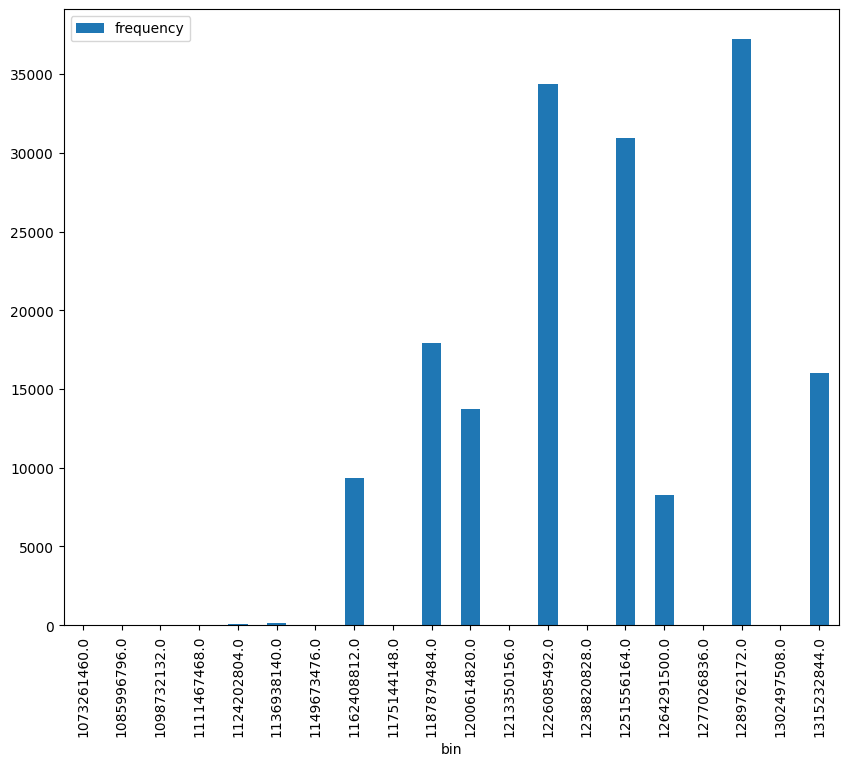

In [ ]:
plotBar(user_df, colName='Joined', bins=20)

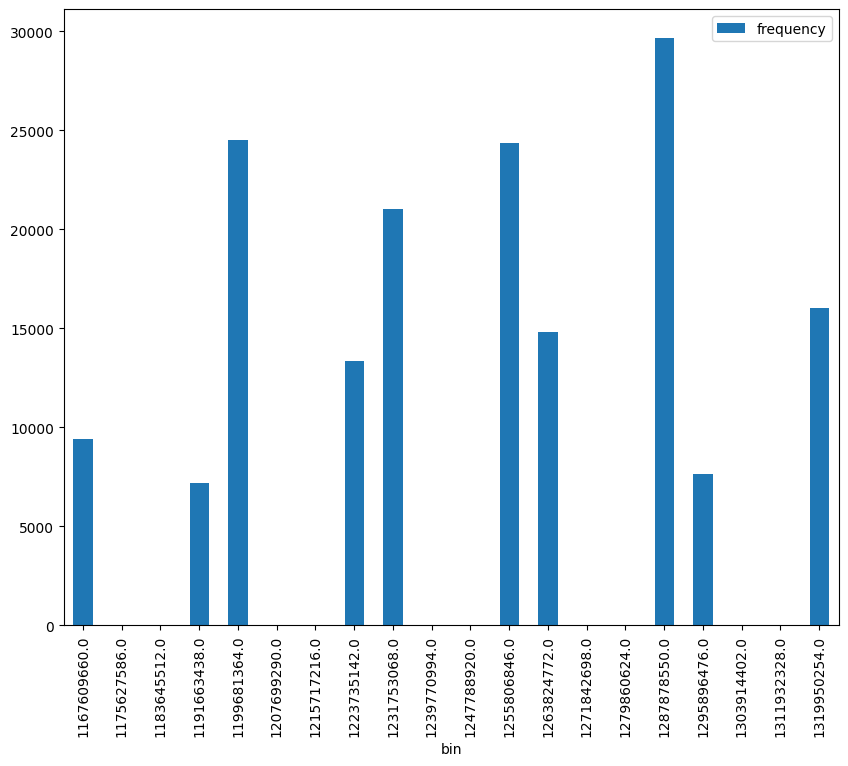

In [ ]:
plotBar(user_df.filter('Joined > 1.16e9'), colName='Joined', bins=20)

As we could see, this could easily be categorized into 6 discrete categories, preferably numbers {0, 0.2, 0.4, 0.6, 0.8, 1}, since the distribution is quite equally, unlike the case of Birthday.

We shall use kNN clustering with k=6 for this.

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col, isnan
from pyspark.sql.types import DoubleType
cur_col = 'Joined'

temp_df = user_df.select('user_id', cur_col)\
    .filter(col(cur_col).isNotNull() & ~isnan(col(cur_col)) & col(cur_col).cast('double').isNotNull())\
    .withColumn(cur_col+'_k', col(cur_col).cast(DoubleType()))\
    .drop(cur_col).withColumnRenamed(cur_col+'_k', cur_col)

vec = VectorAssembler(inputCols=[cur_col], outputCol='features')
col_df = vec.transform(temp_df)

# Trains a k-means model.
kmeans = KMeans().setK(6).setSeed(1)
model = kmeans.fit(col_df)

# Make predictions
predictions = model.transform(col_df)

In [ ]:
user_df = user_df.join(predictions.select('user_id', cur_col, 'prediction'), [cur_col, 'user_id'], 'left')\
    .withColumnRenamed('prediction', cur_col+'_cat')\
    .drop(cur_col)

Then we take care of missing data, firstly by checking if there exists.

In [ ]:
print(user_df.filter(is_missing(cur_col)).count())

0


#### Days Watched

This column shows the number of days user has spent watching anime. The more experience one has with watching, one could judge and rate anime titles more accurately.

Hence, we use this column, with the name changed for easier SQL queries.

In [ ]:
user_df = user_df.withColumnRenamed('Days Watched', 'Days_Watched')

We examine value distribution.

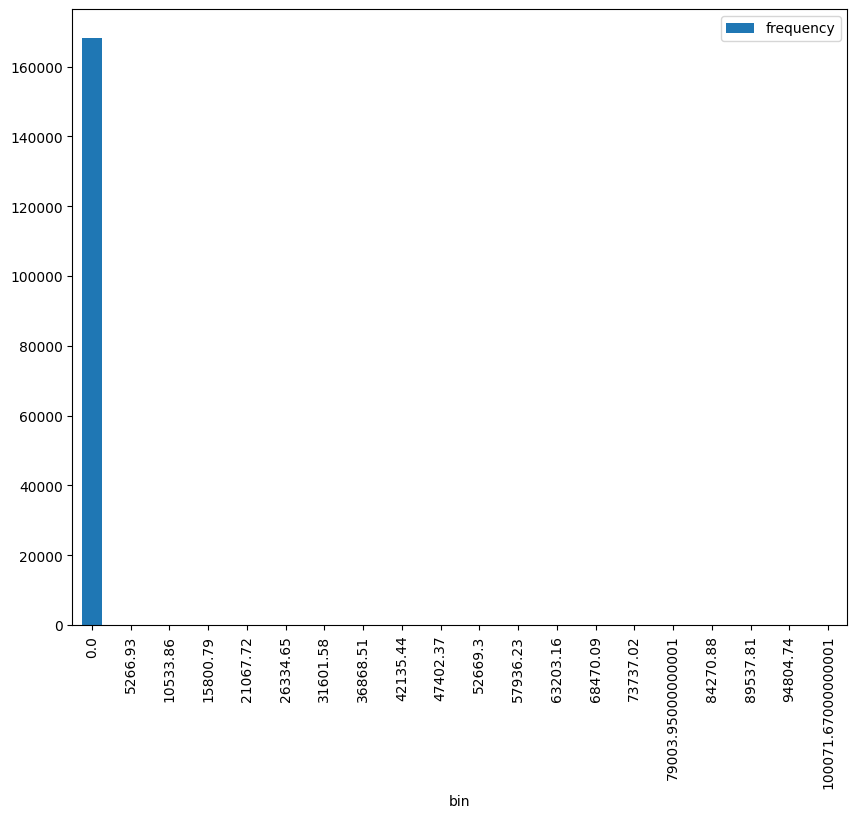

In [ ]:
plotBar(user_df, colName='Days_Watched', bins=20)

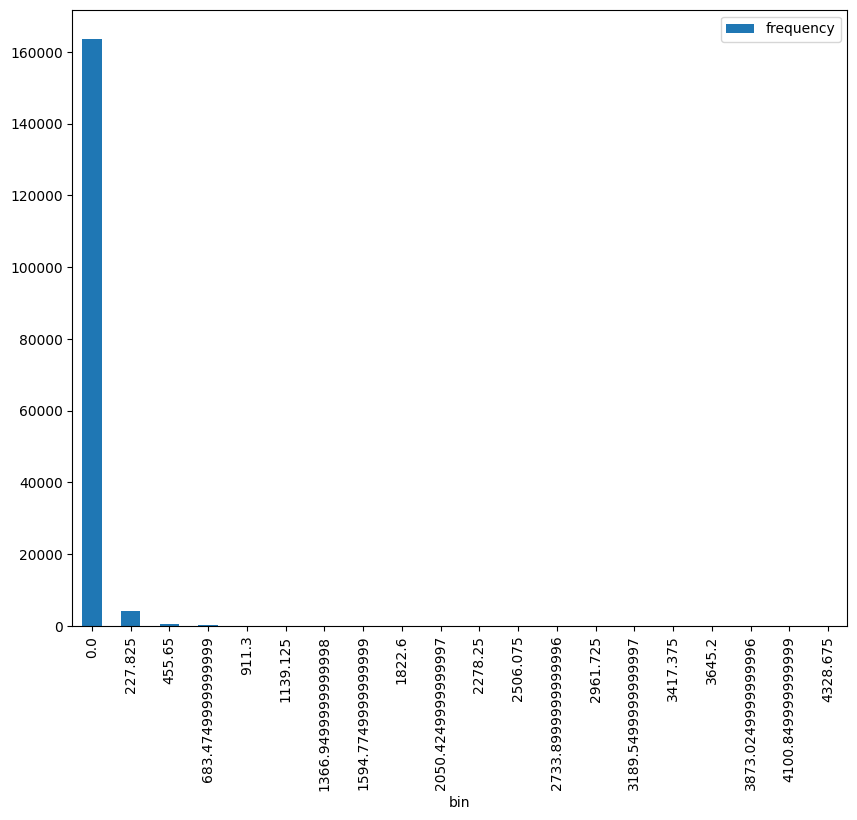

In [ ]:
plotBar(user_df.filter('Days_Watched < 5267'), colName='Days_Watched', bins=20)

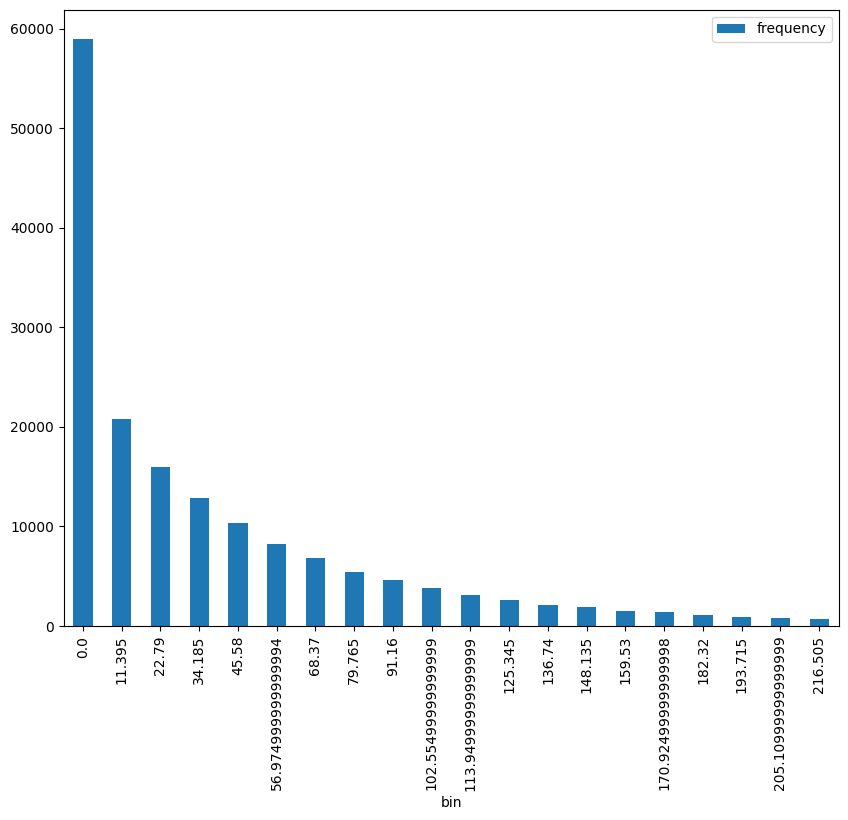

In [ ]:
plotBar(user_df.filter('Days_Watched < 228'), colName='Days_Watched', bins=20)

As expected, the more days spent watching, the fewer users achieving such. The more time one spends watching anime, the more they can observe and rate anime titles more correctly. And the difference between experienced watchers (such as 1000 and 2000 hours) is not as much as between inexperienced (10 hours) and experienced (500 hours).

We shall perform log transformation then normalization and do not perform any outlier elimination.

In [ ]:
from pyspark.sql.functions import log10, col
user_df = user_df.withColumn('Days_Watched_log', log10(col('Days_Watched')+1.0))
user_df = user_df.drop('Days_Watched').withColumnRenamed('Days_Watched_log', 'Days_Watched')

Then we check missing data.

In [ ]:
print(user_df.filter(is_missing('Days_Watched')).count())

6


We fill the missing data by value 0, since the frequency is very high in this column.

In [ ]:
user_df = user_df.na.fill({'Days_Watched': 0})

#### Mean Score

This column indicates the mean score the user rates in the platform, on average. The main problem is it being reflected better by the rating dataset.

Hence, our choice is to drop it.

In [ ]:
user_df = user_df.drop('Mean Score')

#### Watching, On Hold, Dropped, Plan to Watch, Total Entries, Completed, Rewatched, Episodes Watched

There columns shall describe user's common behaviors on the platform implicitly. Since it is completely expected that as these numbers go up, the frequencies go down.

The best way to grasp these columns is to analyze their correlations.

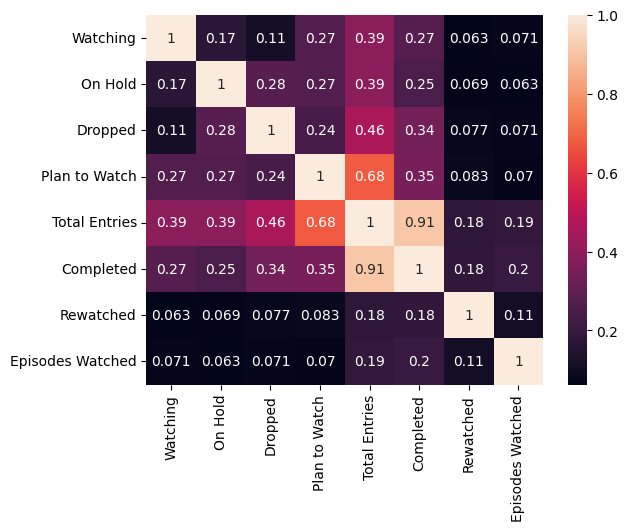

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.heatmap(user_df.select('Watching','On Hold', 'Dropped', 'Plan to Watch', 'Total Entries', 'Completed', 'Rewatched', 'Episodes Watched')\
            .toPandas().corr(), annot=True)
plt.rcParams['figure.figsize'] = (20, 8)
plt.show()

It is pretty clear that we shall keep columns Watching, Rewatched, Episodes Watched as they show the least correlations to the other columns.

On the other hand, we drop Total Entries as it is the sum of Watching, On Hold, Dropped, Plan to Watch, and the correlation with other columns is too much.


In [ ]:
user_df = user_df.drop('Total Entries')

##### On Hold, Dropped, Plan to Watch, Completed

For the other 5 columns, it is best that we use PCA to deal with their very high correlations, and reduce it down to one column. Since PCA cannot deal with missing values, we shall examine the value distribution of these columns.

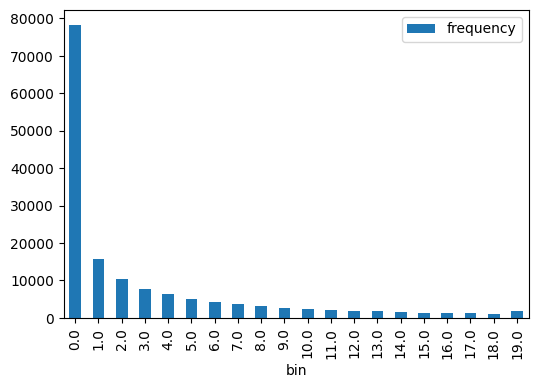

In [ ]:
plotBar(user_df.withColumnRenamed('On Hold', 'On_Hold').filter('On_Hold <= 20'), colName='On_Hold', bins=20, Figsize=(6, 4))

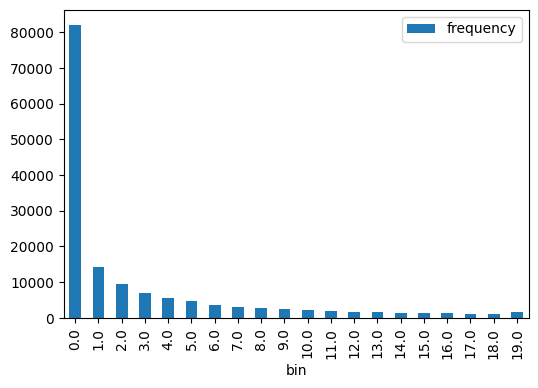

In [ ]:
plotBar(user_df.filter('Dropped <= 20'), colName='Dropped', bins=20, Figsize=(6, 4))

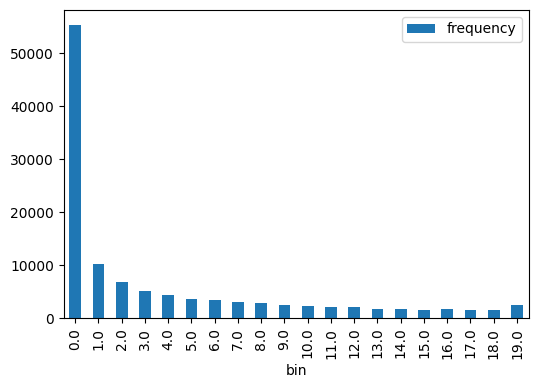

In [ ]:
plotBar(user_df.withColumnRenamed('Plan to Watch', 'p').filter('p <= 20'), colName='p', bins=20, Figsize=(6, 4))

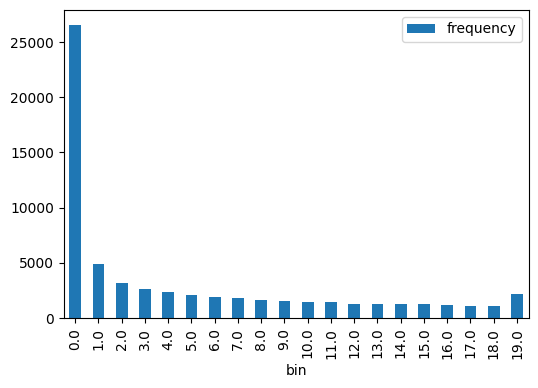

In [ ]:
plotBar(user_df.filter('Completed <= 20'), colName='Completed', bins=20, Figsize=(6, 4))

That is why it is fine to fill the missing data with 0, since its frequency is way too high.

In [ ]:
user_df = user_df.na.fill({'On Hold':0, 'Dropped':0, 'Plan to Watch':0, 'Completed':0})

In [ ]:
# Nice code presentation is brought to you by Colab coding AI assistant.
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.sql.functions import col, isnan
from pyspark.sql.types import DoubleType

cur_cols = ['On Hold', 'Dropped', 'Plan to Watch', 'Completed']
vec = VectorAssembler(inputCols=cur_cols, outputCol='features')
col_df = vec.transform(user_df.select('user_id', *cur_cols)\
      .withColumn('On Hold_p', col('On Hold').cast(DoubleType())).drop('On Hold')
          .withColumnRenamed('On Hold_p', 'On Hold')\
      .withColumn('Dropped_p', col('Dropped').cast(DoubleType())).drop('Dropped')\
          .withColumnRenamed('Dropped_p', 'Dropped')\
      .withColumn('Plan to Watch_p', col('Plan to Watch').cast(DoubleType())).drop('Plan to Watch')\
          .withColumnRenamed('Plan to Watch_p', 'Plan to Watch')\
      .withColumn('Completed_p', col('Completed').cast(DoubleType())).drop('Completed')\
          .withColumnRenamed('Completed_p', 'Completed')\
      )

pca = PCA(k=1, inputCol='features', outputCol='pca')
model = pca.fit(col_df)

pca_df = model.transform(col_df)

user_df = user_df.join(pca_df.select('user_id', 'pca'), 'user_id', 'left').drop(*cur_cols)

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
user_df = user_df.withColumn('PCA', udf(lambda x: float(list(x)[0]), DoubleType())('pca')).drop('pca')

##### Watching, Rewatched, Episodes Watched

We shall deal with missing values, by filling with 0 as explained above for all 7 columns in question.

In [ ]:
user_df = user_df.na.fill({'Watching':0, 'Rewatched':0, 'Episodes Watched':0})

### Final touches

Dimension reduction

In [ ]:
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.sql.types import DoubleType

for i in user_df.columns:
    if i != 'user_id':
        user_df = user_df.withColumn(i, col(i).cast(DoubleType()))

vec = VectorAssembler(inputCols=[i for i in user_df.columns if i != 'user_id'], outputCol='features', handleInvalid='skip')
temp_df = vec.transform(user_df)

pca = PCA(k=1, inputCol='features', outputCol='pca')
model = pca.fit(temp_df)

pca_df = model.transform(temp_df)

pca_df = pca_df.select('user_id', 'pca')\
    .withColumn('PCA', udf(lambda x: float(list(x)[0]), DoubleType())('pca'))

### Saving data

User embeddings dataset

In [ ]:
save_df_to_csv(pca_df.select('user_id', 'PCA'), user_dataset_output, header=True)

## Anime dataset

### Dataset

In [ ]:
anime_df = spark.read\
    .option("header", True)\
    .option("escape", '"')\
    .option("multiline", True)\
    .option("sep", ",")\
    .csv(anime_dataset_input, inferSchema=True)

anime_embed_columns = {}

# element: UNKNOWN
anime_df = anime_df.replace({'UNKNOWN': None, 'Unknown': None})

# change column names for better SQL
anime_df = anime_df.withColumnRenamed('Scored By', 'Scored_By')

In [ ]:
# check missing values
for i in anime_df.columns:
    print(i, anime_df.filter(is_missing(i)).count())

anime_id 0
Name 0
English name 14577
Other name 128
Score 9213
Genres 4929
Synopsis 0
Type 74
Episodes 611
Aired 0
Premiered 19399
Status 0
Producers 13350
Licensors 20170
Studios 10526
Source 3689
Duration 663
Rating 669
Rank 4612
Popularity 0
Favorites 0
Scored_By 9213
Members 0
Image URL 0


### Data preprocessing

#### Name, English name, Other name

Since the problem is about recommendation based on user's taste, it is expected that these features have nothing to do with our recommendation system.

In [ ]:
anime_df = anime_df.drop("Name", "English name", "Other name")

#### Score

This is average score for anime titles on the platform, which shall be implied in the rating dataset.

Hence, we do not need this column.

In [ ]:
anime_df = anime_df.drop("Score")

#### Genres

Since the column is categorical and the label order in Genres is not important, as well as all genres should be included, we use one-hot encoding with 0 support.

In [ ]:
anime_df = oneHotEncoding(anime_df, "Genres", support=0)

#### Synopsis

Synopsis is description of an anime title and has quite some impact to user's taste. However we temporarily leave this out for simplicity and lack of time.

In [ ]:
anime_df = anime_df.drop("Synopsis")

#### Type

Similar to Genres, we use one-hot encoding here.

In [ ]:
anime_df.select("Type").groupBy("Type").count().show()

+-------+-----+
|   Type|count|
+-------+-----+
|     TV| 7597|
|   NULL|   74|
|Special| 2558|
|    OVA| 4076|
|  Music| 2686|
|  Movie| 4381|
|    ONA| 3533|
+-------+-----+



With a small amount of NULL rows, we shall fill them with mode: TV, simply because TV dominates all the values.

In [ ]:
anime_df = anime_df.na.fill({'Type': 'TV'})

Then we perform one-hot encoding

In [ ]:
anime_df= oneHotEncoding(anime_df, "Type")

#### Episodes + Aired

##### Aired

The format of Aired is in the form of "(start date) to (end date)", so we perform splitting into two columns.

In [ ]:
# column: Aired
from pyspark.sql.functions import split, unix_timestamp

split_col = split(anime_df["Aired"], " to ", 2)
anime_df = anime_df.withColumn("F1", split_col.getItem(0)).withColumn("F2", split_col.getItem(1))
anime_df = anime_df.withColumn("air_start", unix_timestamp(col("F1"), "MMM d, yyyy"))\
    .withColumn("air_end", unix_timestamp(col("F2"), "MMM d, yyyy"))\
    .drop("F1", "F2", "Aired")

anime_df.select("air_start", "air_end").show()

+----------+----------+
| air_start|   air_end|
+----------+----------+
| 891561600| 924912000|
| 891388800| 907113600|
|1025654400|1040774400|
|1096502400|1127952000|
|1112745600|1205884800|
|1113523200|1127779200|
|1031702400|1063152000|
|1082160000|1140220800|
|1081296000|1127865600|
|1033603200|1170892800|
| 940377600|      NULL|
|1002672000|1111536000|
|1097020800|1103068800|
|1096934400|1112054400|
|1097020800|1112140800|
|1050537600|1064448000|
|1114732800|1130457600|
|1097539200|1142294400|
|1097193600|1112313600|
| 812764800| 827884800|
+----------+----------+
only showing top 20 rows



##### Missing values

In [ ]:
for i in ['air_start', 'air_end', 'Episodes']:
    print(i, anime_df.filter(is_missing(i)).count())

air_start 4815
air_end 15568
Episodes 611


Most animes tend to have airing schedule of one episode per week, hence we can use one column to help filling the other.

In [ ]:
from pyspark.sql.functions import when, col

# episode to aired
anime_df = anime_df\
.withColumn('air_end', when(is_missing('air_end'), col('air_start')+(col('Episodes')-1)*60*60*24*7).otherwise(col('air_end')))

anime_df = anime_df\
.withColumn('air_start', when(is_missing('air_start'), col('air_end')-(col('Episodes')-1)*60*60*24*7).otherwise(col('air_start')))

# aired to episode
anime_df = anime_df\
.withColumn('Episodes', when(is_missing('Episodes'), (col('air_end')-col('air_start'))/(60*60*24*7)+1).otherwise(col('Episodes')))

Check missing values again.

In [ ]:
for i in ['air_start', 'air_end', 'Episodes']:
    print(i, anime_df.filter(is_missing(i)).count())

air_start 4795
air_end 5079
Episodes 610


Examining value distribution.

###### Episodes

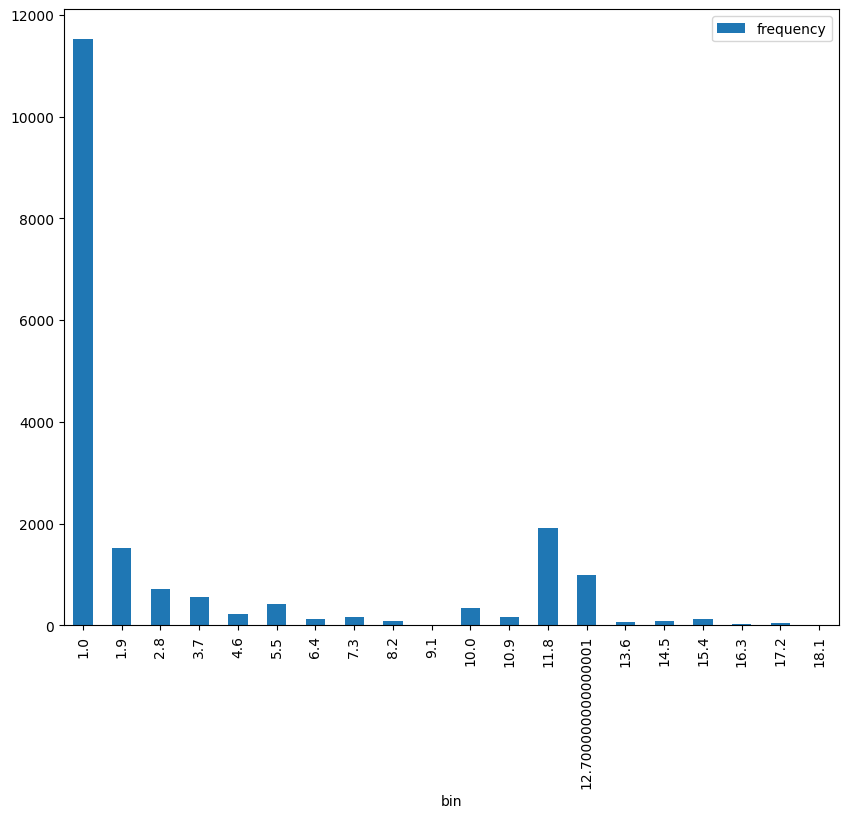

In [ ]:
plotBar(anime_df.filter('Episodes < 20'), colName='Episodes', bins=20)

Since most animes have only one episode, there should be no problem when we fill values with that.

In [ ]:
anime_df = anime_df.na.fill({'Episodes': 1})

###### Aired

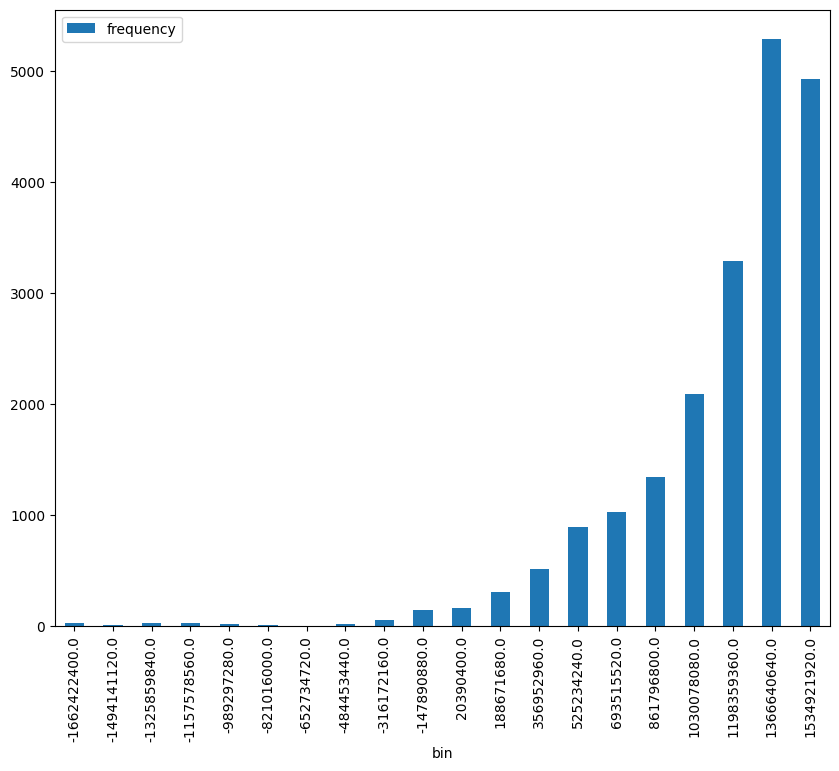

In [ ]:
plotBar(anime_df, colName='air_start', bins=20)

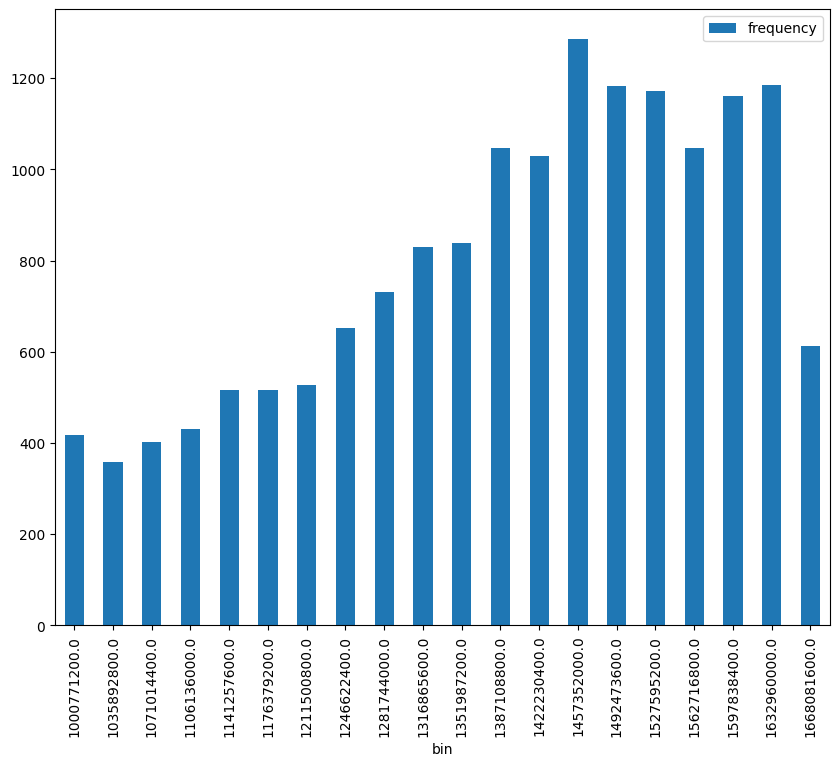

In [ ]:
plotBar(anime_df.filter('air_start > 1e9'), colName='air_start', bins=20)

Since the distribution looks fine, we shall take the mean, and this shall also go to the air_end column as well.

In [ ]:
from pyspark.sql.functions import mean
anime_df = anime_df.na.fill({'air_start': anime_df.select(mean('air_start')).collect()[0][0]})
anime_df = anime_df.na.fill({'air_end': anime_df.select(mean('air_end')).collect()[0][0]})

#### Premiered

Since some users might have the tendency to watch the latest titles, and so as some for the older titles for nostalgia, trendy eras, etc., we shall use this feature. The feature is in the form of season and year, which we shall transform into real numbers, which we will normalize later.

In [ ]:
from pyspark.sql.functions import split, col

split_col = split(anime_df["Premiered"], " ", 2)
anime_df = anime_df.withColumn("F1", split_col.getItem(0)).withColumn("F2", split_col.getItem(1))
anime_df = anime_df.na.replace(['spring', 'summer', 'fall', 'winter'], ['0', '0.25', '0.5', '0.75'], 'F1')\
    .withColumn("Premiered_f", col('F1')+col('F2')).drop("Premiered", "F1", "F2").withColumnRenamed("Premiered_f", "Premiered")

Since we have missing values, we shall examine the value distribution.

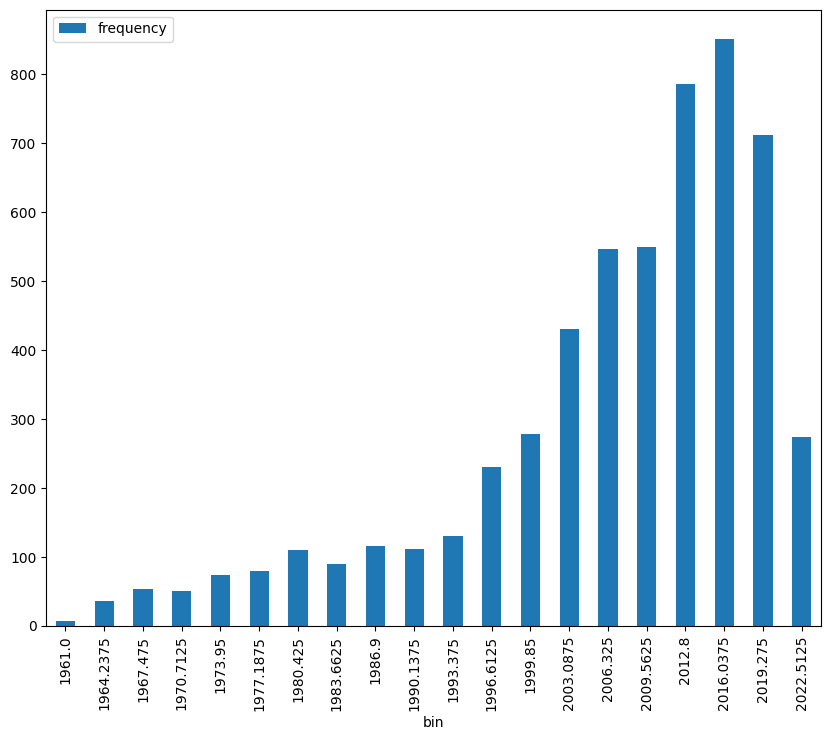

In [ ]:
plotBar(anime_df, colName='Premiered', bins=20)

Since the value distribution is mildly negatively skewed, we shall not perform any transformation, and fill with mode.

In [ ]:
from pyspark.sql.functions import mode
anime_df = anime_df.na.fill({'Premiered': anime_df.select(mode('Premiered')).collect()[0][0]})

#### Status

List of unique values:

In [ ]:
anime_df.select('Status').groupBy('Status').count().show()

+----------------+-----+
|          Status|count|
+----------------+-----+
|Currently Airing|  347|
|   Not yet aired|  488|
| Finished Airing|24070|
+----------------+-----+



Since the list is short, we shall perform one-hot encoding with no support without any issue.

In [ ]:
anime_df = oneHotEncoding(anime_df, "Status", support=0)

#### Producers

In [ ]:
uVal = unique_categories(anime_df, "Producers",show=False)
print(uVal)

{'Producers_Fuji TV': 372, 'Producers_TAP': 4, 'Producers_Shueisha': 307, 'Producers_Yomiuri Telecasting': 92, 'Producers_TMS-Kyokuchi': 4, 'Producers_Shogakukan': 106, 'Producers_TV Asahi': 186, 'Producers_NHK': 827, 'Producers_Sotsu': 320, 'Producers_Nippon Television Network': 154, 'Producers_Ajia-do': 4, 'Producers_Sakura Production': 2, 'Producers_Group TAC': 36, 'Producers_TOHO animation': 135, 'Producers_Sanrio': 207, 'Producers_Glovision': 56, 'Producers_TV Tokyo': 573, 'Producers_TriF Studio': 3, 'Producers_Akatsuki': 9, 'Producers_Shogakukan-Shueisha Productions': 164, 'Producers_Pony Canyon': 390, 'Producers_Hakusensha': 42, 'Producers_BS11': 134, 'Producers_Crunchyroll': 91, 'Producers_Contents Seed': 25, 'Producers_WOWMAX': 5, 'Producers_Twin Engine': 26, 'Producers_Aniplex': 580, 'Producers_Movic': 398, 'Producers_AT-X': 381, 'Producers_Tokyo MX': 174, 'Producers_Q-Tec': 33, 'Producers_Docomo Anime Store': 73, 'Producers_Medicos Entertainment': 33, 'Producers_Yomiuri TV E

Too many columns so we have to add support. Firstly we have to plot the frequencies of the categories.

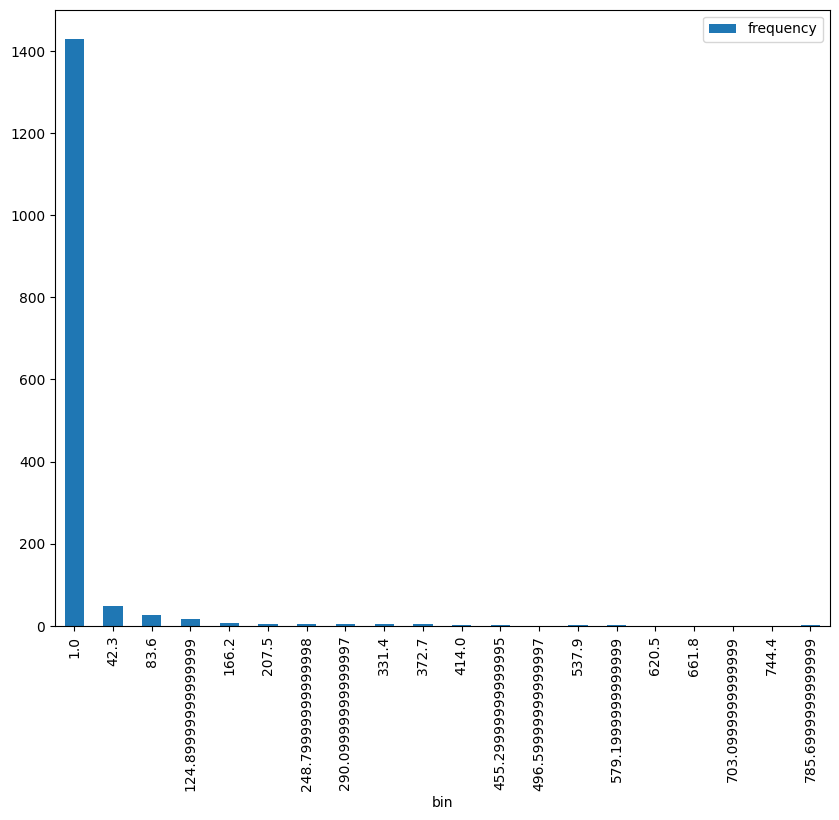

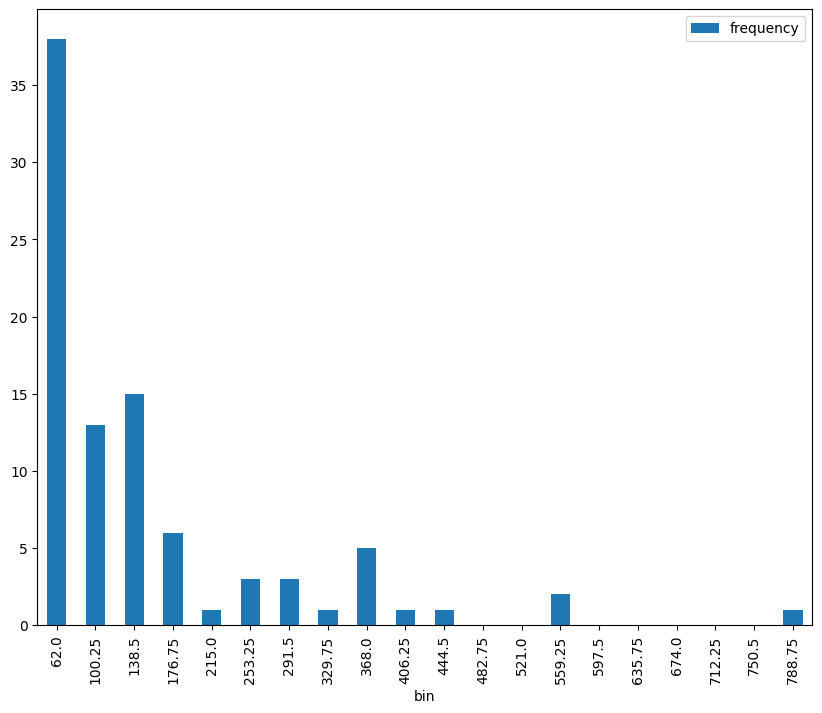

In [ ]:
uVal_df = spark.createDataFrame(pd.DataFrame(list(uVal.values()), columns=['col1']))
plotBar(uVal_df, "col1")
plotBar(uVal_df.where("col1 > 60"), "col1")

In [ ]:
print(uVal_df.count())
print(uVal_df.where("col1 >= 100").count())
print(uVal_df.where("col1 >= 150").count())
print(uVal_df.where("col1 >= 200").count())

1548
56
37
21


So we shall get support = 100 for 56 entries, in order to avoid having too much features causing overfitting.

In [ ]:
anime_df= oneHotEncoding(anime_df, "Producers", support=100)

#### Licensors

In [ ]:
uVal = unique_categories(anime_df, "Licensors")
print(len(uVal))

{'Licensors_Funimation': 1211, 'Licensors_Bandai Entertainment': 201, 'Licensors_Hasbro': 3, 'Licensors_NIS America': 55, 'Licensors_Inc.': 55, 'Licensors_Crunchyroll': 104, 'Licensors_Discotek Media': 491, 'Licensors_Sentai Filmworks': 927, 'Licensors_Aniplex of America': 239, 'Licensors_ADV Films': 305, 'Licensors_Kitty Media': 127, 'Licensors_Media Blasters': 288, 'Licensors_Ponycan USA': 28, 'Licensors_VIZ Media': 199, 'Licensors_Geneon Entertainment USA': 181, 'Licensors_SoftCel Pictures': 30, 'Licensors_Eleven Arts': 19, 'Licensors_4Kids Entertainment': 43, 'Licensors_Central Park Media': 153, 'Licensors_AnimEigo': 39, 'Licensors_NYAV Post': 67, 'Licensors_GKIDS': 71, 'Licensors_Nozomi Entertainment': 142, 'Licensors_Manga Entertainment': 64, 'Licensors_Ascendent Animation': 9, 'Licensors_Enoki Films': 12, 'Licensors_Maiden Japan': 67, 'Licensors_Tokyopop': 14, 'Licensors_The Pokemon Company International': 44, 'Licensors_Disney Platform Distribution': 18, 'Licensors_Urban Vision

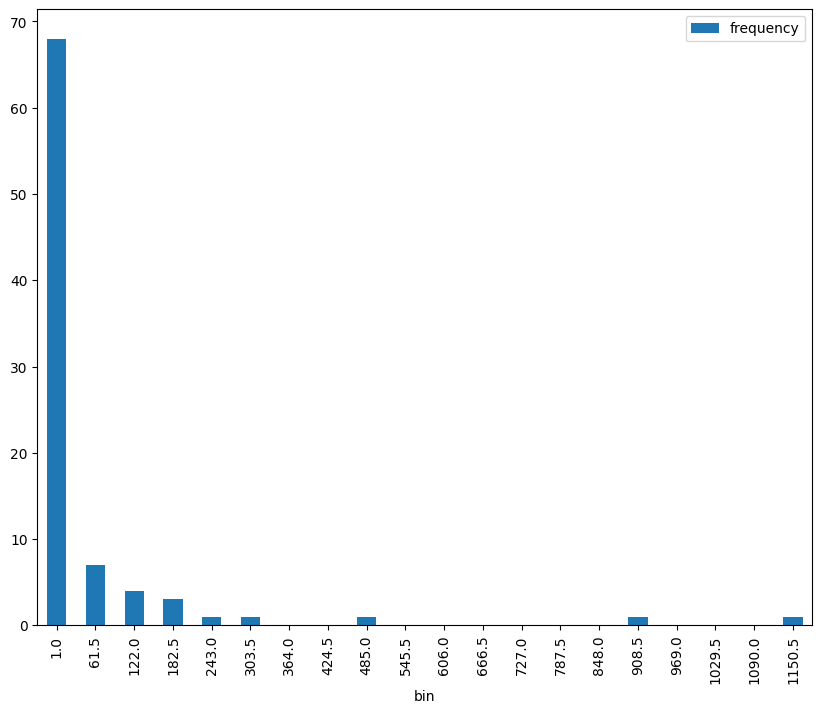

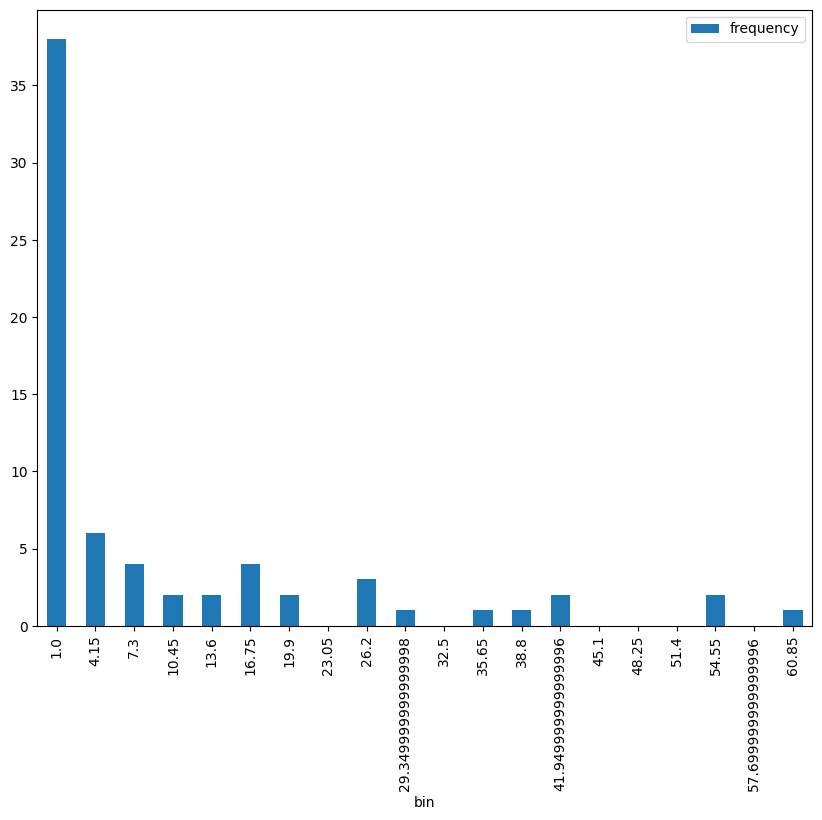

In [ ]:
uVal_df = spark.createDataFrame(pd.DataFrame(list(uVal.values()), columns=['col1']))
plotBar(uVal_df, "col1")
plotBar(uVal_df.where("col1 < 65"), "col1")

In [ ]:
print(uVal_df.count())
print(uVal_df.where("col1 >= 30").count())
print(uVal_df.where("col1 >= 50").count())
print(uVal_df.where("col1 >= 100").count())

87
26
21
13


In [ ]:
anime_df= oneHotEncoding(anime_df, "Licensors", support=100)

#### Studios

In [ ]:
uVal = unique_categories(anime_df, "Studios", False)
print(len(uVal))

1043


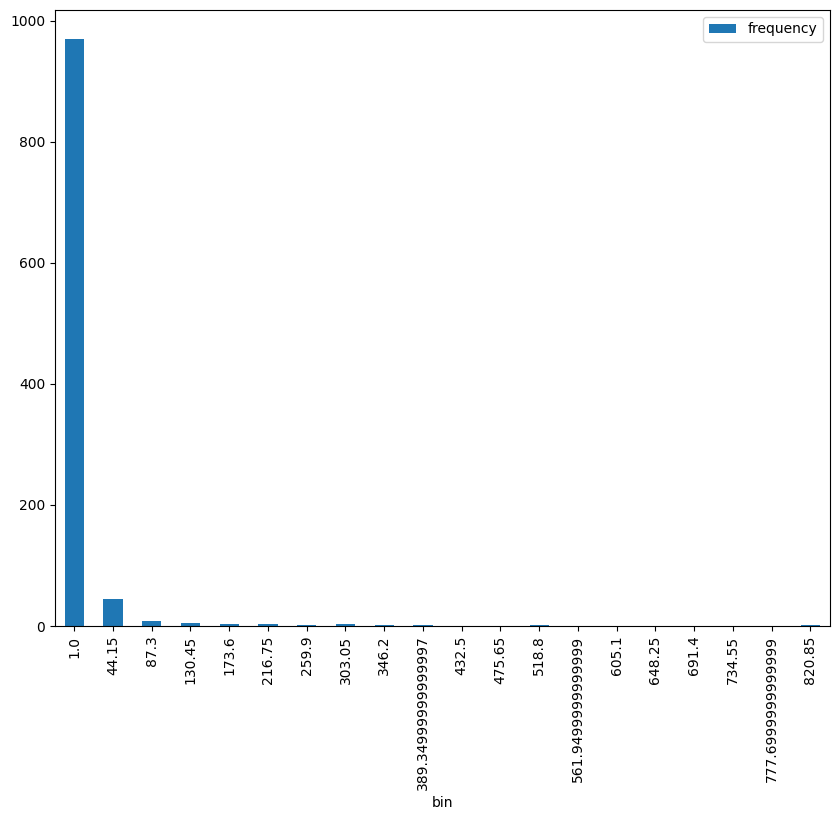

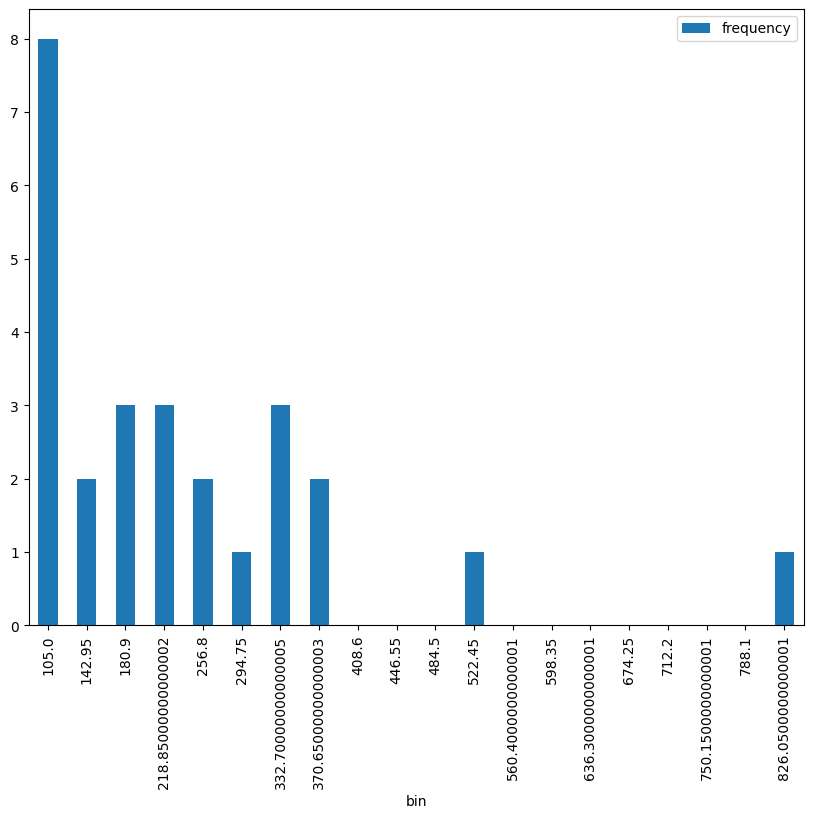

In [ ]:
uVal_df = spark.createDataFrame(pd.DataFrame(list(uVal.values()), columns=['col1']))
plotBar(uVal_df, "col1")
plotBar(uVal_df.where("col1 > 100"), "col1")

In [ ]:
print(uVal_df.count())
print(uVal_df.where("col1 >= 100").count())
print(uVal_df.where("col1 >= 150").count())

1043
26
18


In [ ]:
anime_df = oneHotEncoding(anime_df, "Studios", support=100)

#### Source

In [ ]:
uVal = unique_categories(anime_df, "Source", False)
print(len(uVal))

16


The number of categories is small, so we do not reduce.

In [ ]:
anime_df = oneHotEncoding(anime_df, "Source", support=100)

#### Duration

The format is "? hr ? min (per ep)", we shall convert to a single number representing the duration for each episode in minutes.

Then the numbers will be normalized later.

In [ ]:
import pandas as pd

temp_df = anime_df.select("Duration")
#temp_df.show()

data = temp_df.toPandas()["Duration"].tolist()
new_d = []
for i in range(len(data)):
    if data[i] is not None:
        S = data[i].split(" per ep")[0]
        if "min" not in S:
            if "hr" in S:
                S += " 0 min"
            else:
                S = "0 min " + S
        if "hr" not in S:
            S = "0 hr " + S
        if "sec" not in S:
            S += " 0 sec"

        h, m, s = S.split(" hr ")[0], S.split(" hr ")[1].split(" min ")[0], S.split(" hr ")[1].split(" min ")[1].split(" sec")[0]
        new_d.append(int(h)*3600+int(m)*60+int(s))
    else:
        new_d.append(None)

data = spark.createDataFrame(pd.DataFrame({
    'Duration': data,
    'Duration_f': new_d
})).dropDuplicates()

anime_df = anime_df.join(data, 'Duration', 'left').drop("Duration").withColumnRenamed(existing="Duration_f", new="Duration").dropDuplicates()                   #p4stwi2x

We fill in the missing values by the common duration of a televised anime: 30 minutes.

In [ ]:
anime_df = anime_df.na.fill({'Duration': 30*60})

#### Rating

This feature shall be used to filter the recommendation list by user's age and/or filter options, hence it is not to be in the processing.

In [ ]:
anime_df = anime_df.drop("Rating")

#### Rank

From the author: "The rank of the anime based on popularity or other criteria". Since the metric is not clear and we are here to predict the ranking by ourselves, so it is better to have this feature removed.

In [ ]:
anime_df = anime_df.drop("Rank")

#### Popularity

From the author: "The popularity rank of the anime". It is indeed that the more popular titles are likely to be watched by users, so they should appear higher on our predicted ranking list.

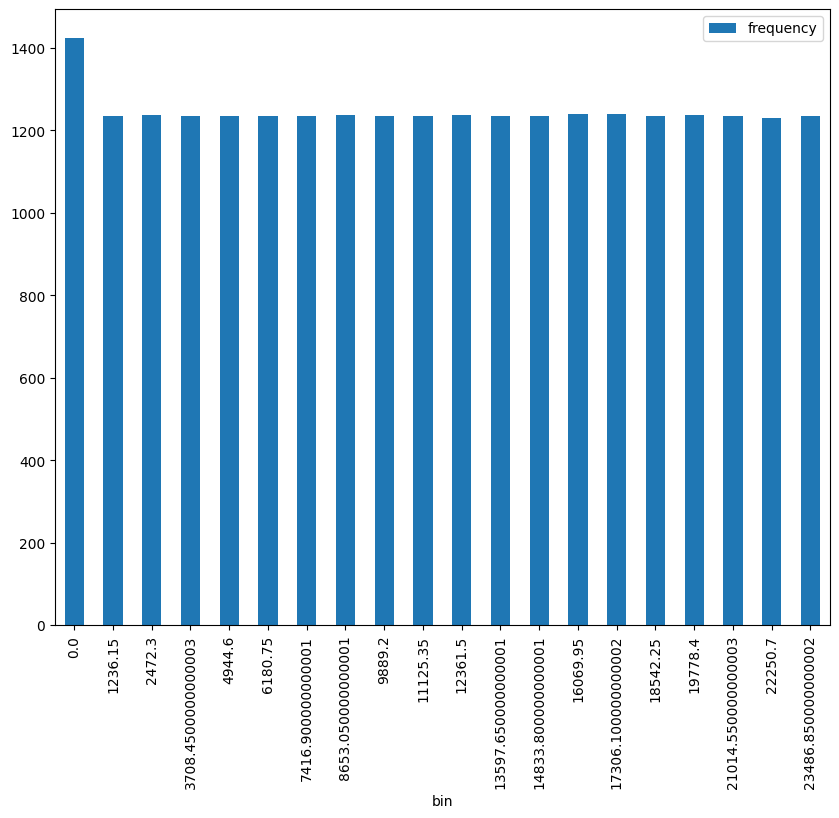

In [ ]:
plotBar(anime_df, "Popularity")

However, it is indeed that this column is just the ranking for the titles, which do not have much value in determining the actual differences between the popularity of two different anime titles. So it is better for us to drop this and come up with a different way to get the popularity.

In [ ]:
anime_df = anime_df.drop("Popularity")

#### Favorites, Members

As we mentioned with the Popularity column, we shall find ways to represent an anime title's popularity. That is why we keep these 2 features, using log transformation as the degree of popularity shall suit that better.

In [ ]:
from pyspark.sql.functions import log10, col
for i in ['Favorites', 'Members']:
    anime_df = anime_df.withColumn(i+'_l', log10(col(i)+1.0))\
        .drop(i).withColumnRenamed(existing=i+'_l', new=i)

This feature suggests the number of times an anime title is scored. As explained from the Popularity feature, this shall determine how popular a title is to be better on our ranking list.

#### Scored By

This column indicates number of users have rated the anime title, which shall be included in the rating dataset.

Hence, we do not need this column.

In [ ]:
anime_df = anime_df.drop("Scored_By")

#### Image URL

The feature has nothing to do with data processing, so the column is expected to be removed.

In [ ]:
anime_df = anime_df.drop("Image URL")

### Final touches

In [ ]:
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.sql.types import DoubleType

for i in anime_df.columns:
    if i != 'anime_id':
        anime_df = anime_df.withColumn(i, col(i).cast(DoubleType()))

vec = VectorAssembler(inputCols=[i for i in anime_df.columns if i != 'anime_id'], outputCol='features', handleInvalid='skip')
temp_df = vec.transform(anime_df)

pca = PCA(k=1, inputCol='features', outputCol='pca')
model = pca.fit(temp_df)

pca_df = model.transform(temp_df)

pca_df = pca_df.select('anime_id', 'pca')\
    .withColumn('PCA', udf(lambda x: float(list(x)[0]), DoubleType())('pca'))

### Saving data

Preprocessed data

In [ ]:
save_df_to_csv(pca_df.select('anime_id', 'PCA'), anime_dataset_output, header=True)

## Main dataset

#### Rating dataset

Read dataset

In [ ]:
rating_df = spark.read.csv(rating_dataset_input, header=True, inferSchema=True)

Formatting

In [ ]:
rating_df = rating_df.select('user_id', 'anime_id', 'rating')

For missing values in column Rating, we simply fill with mean. For missing values in columns anime_id or user_id, unfortunately we would have to drop the rows out since there is insufficient information.

In [ ]:
from pyspark.sql.functions import mean, when, col
rating_df = rating_df.withColumn('rating', when(~is_missing('rating'), col('rating')).otherwise(None))
rating_df = rating_df.na.fill({'rating': rating_df.select(mean('rating')).collect()[0][0]})
rating_df = rating_df.filter(~is_missing('anime_id') & ~is_missing('user_id'))

Secondly, we eliminate duplicate entries: user id & anime id. If there are duplicate, we simply take the average rating.

In [ ]:
from pyspark.sql.functions import avg
rating_df = rating_df.groupBy("user_id", "anime_id").agg(avg("rating").alias("rating"))
rating_df.persist()

DataFrame[user_id: int, anime_id: int, rating: double]

#### Optional: Read pre-prepped side datasets

In [ ]:
user_dataset_output = "/content/drive/MyDrive/stuff/user_embeddings.csv"
anime_dataset_output = "/content/drive/MyDrive/stuff/anime_embeddings.csv"

In [ ]:
anime_df = spark.read\
    .option("header", True)\
    .option("escape", '"')\
    .option("multiline", True)\
    .option("sep", ",")\
    .csv(anime_dataset_output)
user_df = spark.read\
    .option("header", True)\
    .option("escape", '"')\
    .option("multiline", True)\
    .option("sep", ",")\
    .csv(user_dataset_output)

#### Datasets: Join

We perform joining the embedding datasets into one unified dataset.

In [ ]:
user_df = user_df.withColumnRenamed('PCA','uPCA')
anime_df = anime_df.withColumnRenamed('PCA','aPCA')

main_df = rating_df\
    .join(user_df, rating_df['user_id'] == user_df['user_id'], 'left')\
    .join(anime_df, rating_df['anime_id'] == anime_df['anime_id'], 'left')

main_df = main_df.drop(user_df['user_id'], anime_df['anime_id'])

In [ ]:
from pyspark.sql.functions import col
for i in main_df.columns:
    main_df = main_df.withColumn(i, col(i).cast(DoubleType()))

### Final transformation

In [ ]:
main_df = main_df.filter(~is_missing('uPCA') & ~is_missing('aPCA') & ~is_missing('rating') & ~is_missing('user_id') & ~is_missing('anime_id'))

In [ ]:
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.sql.types import DoubleType

vec = VectorAssembler(inputCols=[i for i in main_df.columns if (i != 'user_id' and i != 'anime_id')], outputCol='features')
temp_df = vec.transform(main_df)

pca = PCA(k=1, inputCol='features', outputCol='pca')
model = pca.fit(temp_df)

pca_df = model.transform(temp_df)

## Final results

In [ ]:
pca_df = pca_df.select('user_id', 'anime_id', 'pca')\
    .withColumn('PCA', udf(lambda x: float(list(x)[0]), DoubleType())('pca'))

In [ ]:
save_df_to_csv(pca_df.select('user_id', 'anime_id', 'PCA').withColumnRenamed('PCA', 'rating'), dataset_output_dir + "unified_dataset_prep.csv", header=True)